In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from PIL import Image

# Dataset directories
base_dir = r"C:\Users\Baki Akgun\OneDrive\Masaüstü\Fruit 360\fruits-360_dataset_100x100"
train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

# Helper function to load data using PIL
def load_data_pil(data_dir, img_size=(100, 100)):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(img_size)
            images.append(np.array(img))
            labels.append(class_name)
    return np.array(images), np.array(labels), class_names


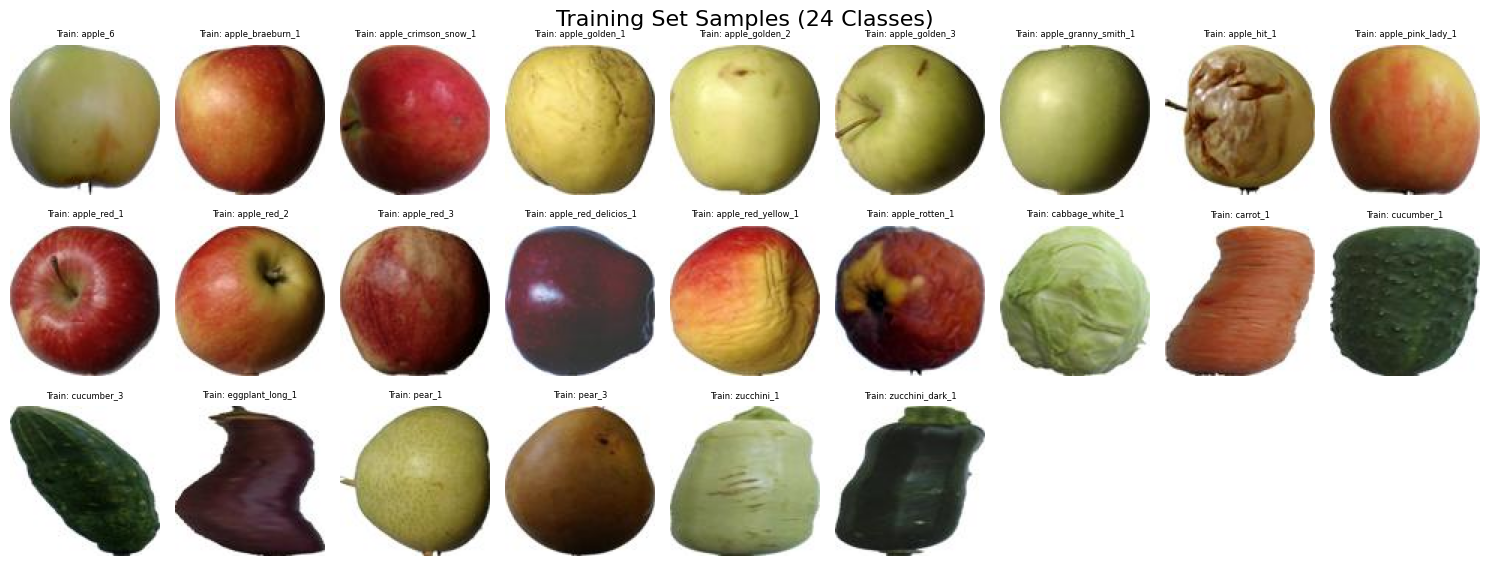

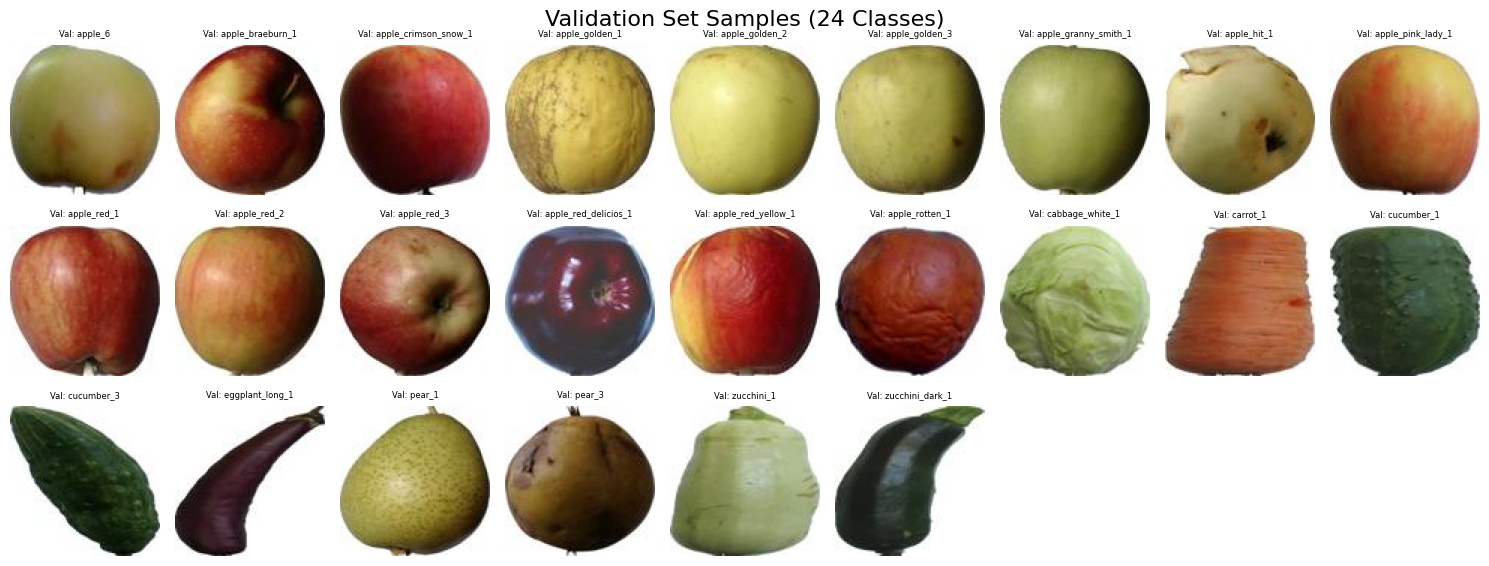

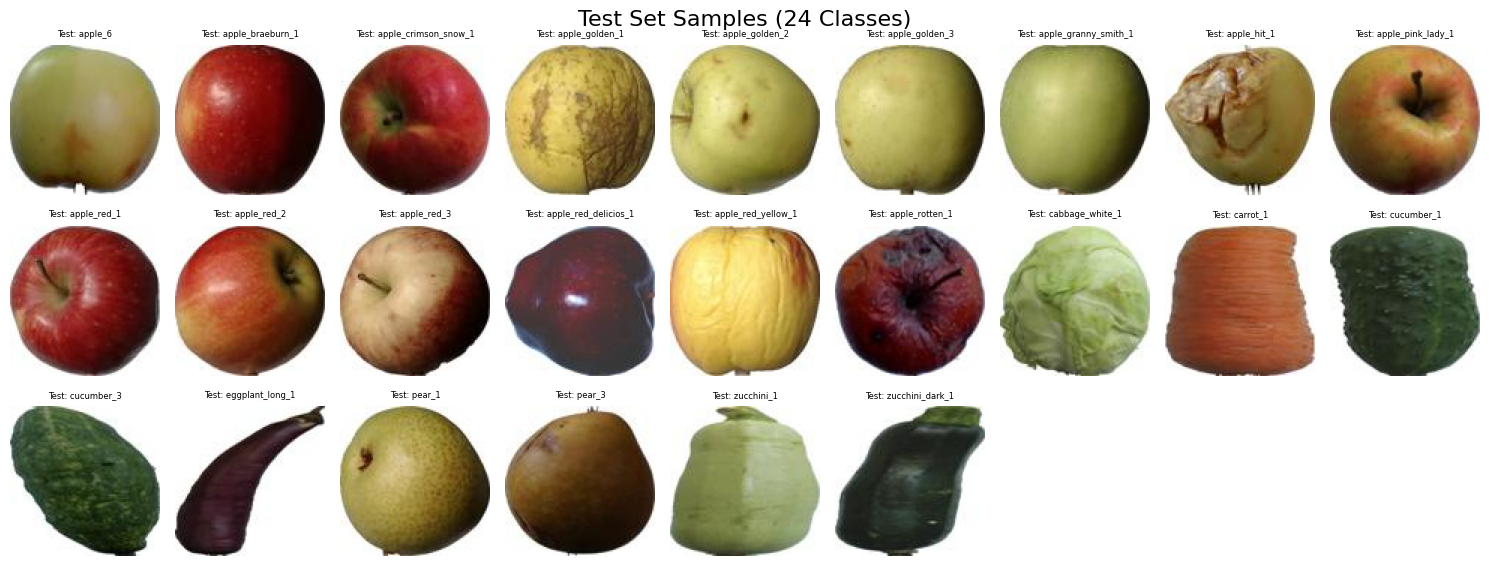

In [2]:
# Her veri seti klasöründen 24 farklı sınıfın birer örneğini alacak fonksiyon
def get_one_sample_per_class(data_dir, img_size=(100, 100)):
    sample_images = []
    sample_labels = []
    class_names = os.listdir(data_dir)[:24]  # İlk 24 sınıfı al (24 sınıf mevcut olduğunu varsayıyoruz)
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        img_file = random.choice(os.listdir(class_path))  # Her sınıftan rastgele bir örnek seç
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).resize(img_size)
        sample_images.append(np.array(img))
        sample_labels.append(class_name)
    return sample_images, sample_labels

# Training, Validation ve Test klasörlerinden örnekleri al
train_samples, train_labels = get_one_sample_per_class(train_dir, img_size=(100, 100))
val_samples, val_labels = get_one_sample_per_class(val_dir, img_size=(100, 100))
test_samples, test_labels = get_one_sample_per_class(test_dir, img_size=(100, 100))

# Show sample images
plt.figure(figsize=(15, 15))

# Training samples
for i, (img, label) in enumerate(zip(train_samples, train_labels)):
    plt.subplot(8, 9, i + 1)  # 8x9'luk bir grid kullanarak görselleri yerleştir
    plt.imshow(img)
    plt.title(f"Train: {label}", fontsize=6)
    plt.axis('off')

plt.suptitle("Training Set Samples (24 Classes)", fontsize=16)
plt.tight_layout()
plt.show()

# Validation samples
plt.figure(figsize=(15, 15))
for i, (img, label) in enumerate(zip(val_samples, val_labels)):
    plt.subplot(8, 9, i + 1)
    plt.imshow(img)
    plt.title(f"Val: {label}", fontsize=6)
    plt.axis('off')

plt.suptitle("Validation Set Samples (24 Classes)", fontsize=16)
plt.tight_layout()
plt.show()

# Test samples
plt.figure(figsize=(15, 15))
for i, (img, label) in enumerate(zip(test_samples, test_labels)):
    plt.subplot(8, 9, i + 1)
    plt.imshow(img)
    plt.title(f"Test: {label}", fontsize=6)
    plt.axis('off')

plt.suptitle("Test Set Samples (24 Classes)", fontsize=16)
plt.tight_layout()
plt.show()


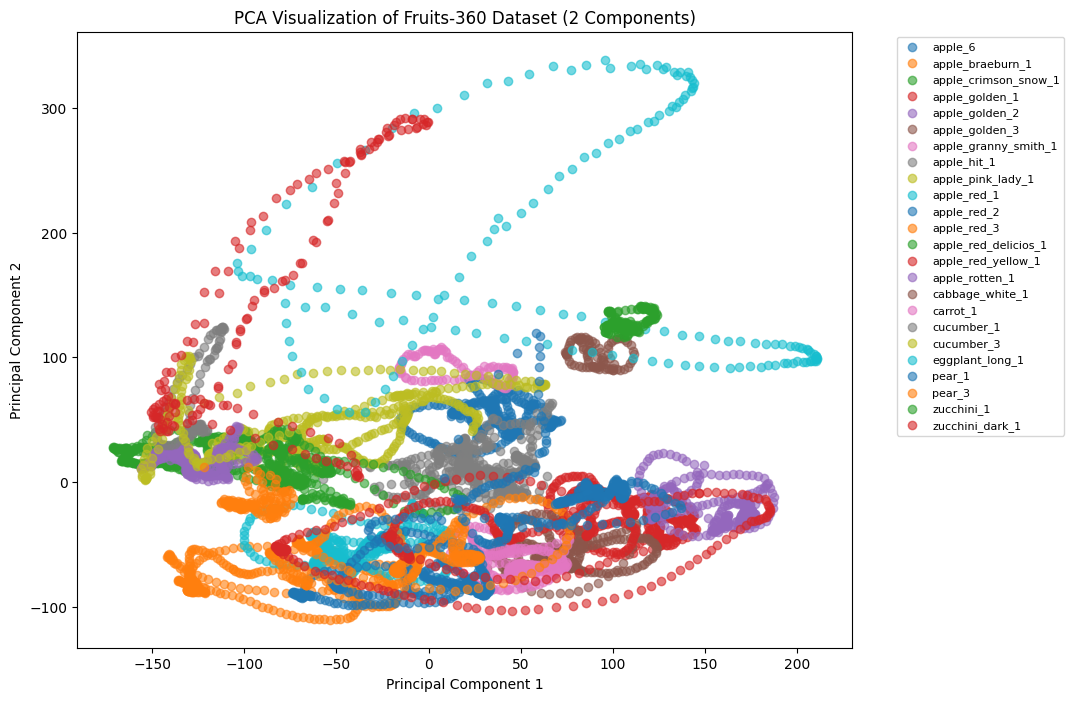

In [3]:
# Load data from all directories (Train, Validation, Test)
train_images_pil, train_labels_pil, class_names_pil = load_data_pil(train_dir, img_size=(100, 100))
val_images_pil, val_labels_pil, _ = load_data_pil(val_dir, img_size=(100, 100))
test_images_pil, test_labels_pil, _ = load_data_pil(test_dir, img_size=(100, 100))

# Flatten the images into 1D vectors
train_images_flat = train_images_pil.reshape(train_images_pil.shape[0], -1)
val_images_flat = val_images_pil.reshape(val_images_pil.shape[0], -1)
test_images_flat = test_images_pil.reshape(test_images_pil.shape[0], -1)

# Normalize the data
scaler = StandardScaler()
train_images_normalized = scaler.fit_transform(train_images_flat)
val_images_normalized = scaler.transform(val_images_flat)
test_images_normalized = scaler.transform(test_images_flat)

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
train_images_pca = pca.fit_transform(train_images_normalized)
val_images_pca = pca.transform(val_images_normalized)
test_images_pca = pca.transform(test_images_normalized)

# Visualize the PCA results
plt.figure(figsize=(10, 8))
for i, label in enumerate(np.unique(train_labels_pil)):
    plt.scatter(train_images_pca[train_labels_pil == label, 0],
                train_images_pca[train_labels_pil == label, 1], label=label, alpha=0.6)

plt.title("PCA Visualization of Fruits-360 Dataset (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.show()

# Convert labels to numeric values (for sklearn models)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels_pil)
y_val_encoded = label_encoder.transform(val_labels_pil)
y_test_encoded = label_encoder.transform(test_labels_pil)


## Traditional Machine Learning Models + PCA

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

# Define models to test
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'GBM': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Function to train and evaluate models
def evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test):
    results = []
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_val_pred = model.predict(X_val)
        
        # Predict on test set
        y_test_pred = model.predict(X_test)
        
        # Calculate performance metrics for Validation set
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred, average='weighted')
        val_recall = recall_score(y_val, y_val_pred, average='weighted')
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        
        # Calculate performance metrics for Test set
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, average='weighted')
        test_recall = recall_score(y_test, y_test_pred, average='weighted')
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')
        
        # Append results to the list
        results.append({
            'Model': model_name,
            'Validation Accuracy': val_accuracy,
            'Validation Precision': val_precision,
            'Validation Recall': val_recall,
            'Validation F1 Score': val_f1,
            'Test Accuracy': test_accuracy,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test F1 Score': test_f1,
        })
    
    return pd.DataFrame(results)

# Evaluate the models on both validation and test sets
model_results = evaluate_models(models, train_images_pca, y_train_encoded, val_images_pca, y_val_encoded, test_images_pca, y_test_encoded)

# Save results to a CSV file
model_results.to_csv('model_results.csv', index=False)

# Display results
model_results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 6231, number of used features: 2
[LightGBM] [Info] Start training from score -2.984719
[LightGBM] [Info] Start training from score -2.968971
[LightGBM] [Info] Start training from score -2.975241
[LightGBM] [Info] Start training from score -3.007192
[LightGBM] [Info] Start training from score -3.007192
[LightGBM] [Info] Start training from score -2.981550
[LightGBM] [Info] Start training from score -2.968971
[LightGBM] [Info] Start training from score -2.588824
[LightGBM] [Info] Start training from score -2.991089
[LightGBM] [Info] Start training from score -3.003951
[LightGBM] [Info] Start training from score -2.975241
[LightGBM] [Info] Start training from score -3.098937
[L

c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Validation Accuracy  Validation Precision  \
0  Random Forest             0.836224              0.836337   
1        XGBoost             0.817277              0.817017   
2       LightGBM             0.821130              0.820247   
3            GBM             0.758189              0.758751   
4            SVM             0.633269              0.609141   

   Validation Recall  Validation F1 Score  Test Accuracy  Test Precision  \
0           0.836224             0.834702       0.839228        0.839196   
1           0.817277             0.815824       0.816399        0.816099   
2           0.821130             0.819935       0.826367        0.825908   
3           0.758189             0.753398       0.755949        0.755770   
4           0.633269             0.603399       0.634727        0.605447   

   Test Recall  Test F1 Score  
0     0.839228       0.838229  
1     0.816399       0.815430  
2     0.826367       0.825258  
3     0.755949       0.752075  
4     0.634727       0.604155

## ANN + PCA

c:\Users\Baki Akgun\New Folder\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2768 - loss: 2.5812 - val_accuracy: 0.3889 - val_loss: 1.5768
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3579 - loss: 1.6255 - val_accuracy: 0.3783 - val_loss: 1.5644
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3814 - loss: 1.5804 - val_accuracy: 0.4277 - val_loss: 1.4836
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4098 - loss: 1.4878 - val_accuracy: 0.4155 - val_loss: 1.4609
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4250 - loss: 1.4701 - val_accuracy: 0.4782 - val_loss: 1.3585
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4766 - loss: 1.3356 - val_accuracy: 0.5074 - val_loss: 1.3180
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5276 - loss: 1.2394 - val_accuracy: 0.5093 - val_loss: 1.1741
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5292 - loss: 1.1793 - val_accuracy: 0.5604 - val_loss:

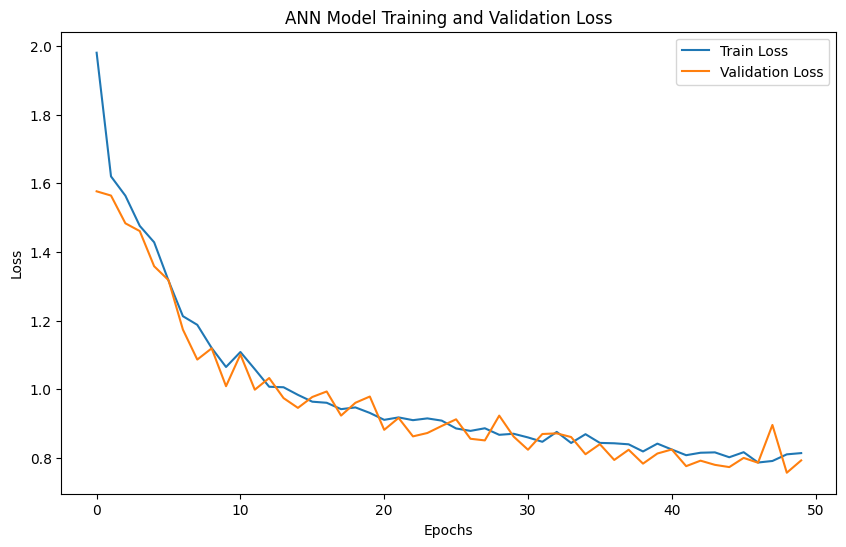

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 6231, number of used features: 2
[LightGBM] [Info] Start training from score -2.984719
[LightGBM] [Info] Start training from score -2.968971
[LightGBM] [Info] Start training from score -2.975241
[LightGBM] [Info] Start training from score -3.007192
[LightGBM] [Info] Start training from score -3.007192
[LightGBM] [Info] Start training from score -2.981550
[LightGBM] [Info] Start training from score -2.968971
[LightGBM] [Info] Start training from score -2.588824
[LightGBM] [Info] Start training from score -2.991089
[LightGBM] [Info] Start training from score -3.003951
[LightGBM] [Info] Start training from score -2.975241
[LightGBM] [Info] Start training from sc

c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Validation Accuracy  Validation Precision  \
0  Random Forest             0.836224              0.836337   
1        XGBoost             0.817277              0.817017   
2       LightGBM             0.821130              0.820247   
3            GBM             0.758189              0.758751   
4            SVM             0.633269              0.609141   
5            ANN             0.672447              0.673919   

   Validation Recall  Validation F1 Score  Test Accuracy  Test Precision  \
0           0.836224             0.834702       0.839228        0.839196   
1           0.817277             0.815824       0.816399        0.816099   
2           0.821130             0.819935       0.826367        0.825908   
3           0.758189             0.753398       0.755949        0.755770   
4           0.633269             0.603399       0.634727        0.605447   
5           0.672447             0.658455       0.672347        0.673869   

   Test Recall  Test F1 Score  
0     0.839228       0.838229  
1     0.816399       0.815430  
2     0.826367       0.825258  
3     0.755949       0.752075  
4     0.634727       0.604155  
5     0.672347       0.658986

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Train ANN Model
def create_ann_model(input_shape):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))  # Number of output classes
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create ANN model
ann_model = create_ann_model(train_images_pca.shape[1])

# Train ANN model and record history
history = ann_model.fit(train_images_pca, y_train_encoded, epochs=50, batch_size=64,
                        validation_data=(val_images_pca, y_val_encoded))

# Visualize Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions for validation and test sets
y_val_pred_ann = np.argmax(ann_model.predict(val_images_pca), axis=1)
y_test_pred_ann = np.argmax(ann_model.predict(test_images_pca), axis=1)

# Evaluate ANN model performance on validation and test sets
ann_val_accuracy = accuracy_score(y_val_encoded, y_val_pred_ann)
ann_val_precision = precision_score(y_val_encoded, y_val_pred_ann, average='weighted')
ann_val_recall = recall_score(y_val_encoded, y_val_pred_ann, average='weighted')
ann_val_f1 = f1_score(y_val_encoded, y_val_pred_ann, average='weighted')

ann_test_accuracy = accuracy_score(y_test_encoded, y_test_pred_ann)
ann_test_precision = precision_score(y_test_encoded, y_test_pred_ann, average='weighted')
ann_test_recall = recall_score(y_test_encoded, y_test_pred_ann, average='weighted')
ann_test_f1 = f1_score(y_test_encoded, y_test_pred_ann, average='weighted')

# ANN Model Evaluation Results
ann_results = {
    'Model': ['ANN'],
    'Validation Accuracy': [ann_val_accuracy],
    'Validation Precision': [ann_val_precision],
    'Validation Recall': [ann_val_recall],
    'Validation F1 Score': [ann_val_f1],
    'Test Accuracy': [ann_test_accuracy],
    'Test Precision': [ann_test_precision],
    'Test Recall': [ann_test_recall],
    'Test F1 Score': [ann_test_f1]
}

# Convert ANN results to DataFrame
ann_results_df = pd.DataFrame(ann_results)

# Evaluate other models
model_results = evaluate_models(models, train_images_pca, y_train_encoded, val_images_pca, y_val_encoded, test_images_pca, y_test_encoded)

# Combine ANN results with other model results
all_results = pd.concat([model_results[[  # Select only the desired columns from model_results
    'Model', 
    'Validation Accuracy', 
    'Validation Precision', 
    'Validation Recall', 
    'Validation F1 Score', 
    'Test Accuracy', 
    'Test Precision', 
    'Test Recall', 
    'Test F1 Score'
]], ann_results_df], ignore_index=True)

# Save the combined results to CSV
all_results.to_csv('model_results.csv', index=False)

# Display the results
print("Combined Model Results:")
all_results


## CNN + PCA

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Load data from all directories (Train, Validation, Test)
train_images_pil, train_labels_pil, class_names_pil = load_data_pil(train_dir, img_size=(100, 100))
val_images_pil, val_labels_pil, _ = load_data_pil(val_dir, img_size=(100, 100))
test_images_pil, test_labels_pil, _ = load_data_pil(test_dir, img_size=(100, 100))

# Flatten the images into 1D vectors
train_images_flat = train_images_pil.reshape(train_images_pil.shape[0], -1)
val_images_flat = val_images_pil.reshape(val_images_pil.shape[0], -1)
test_images_flat = test_images_pil.reshape(test_images_pil.shape[0], -1)

# Normalize the data
scaler = StandardScaler()
train_images_normalized = scaler.fit_transform(train_images_flat)
val_images_normalized = scaler.transform(val_images_flat)
test_images_normalized = scaler.transform(test_images_flat)


# Convert labels to numeric values (for sklearn models)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels_pil)
y_val_encoded = label_encoder.transform(val_labels_pil)
y_test_encoded = label_encoder.transform(test_labels_pil)

# Create a CNN model
model = models.Sequential()

# Convolutional layers (Conv2D layers)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))  # First Conv layer
model.add(layers.MaxPooling2D((2, 2)))  # Max pooling

model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Second Conv layer
model.add(layers.MaxPooling2D((2, 2)))  # Max pooling

model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Third Conv layer
model.add(layers.MaxPooling2D((2, 2)))  # Max pooling

# Flatten layer
model.add(layers.Flatten())

# Fully connected (Dense) layers
model.add(layers.Dense(128, activation='relu'))  # Fully connected layer
model.add(layers.Dropout(0.5))  # Dropout layer
model.add(layers.Dense(len(np.unique(y_train_encoded)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images_pil, y_train_encoded, epochs=30, batch_size=16,
                    validation_data=(val_images_pil, y_val_encoded))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images_pil, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get predictions for calculating precision, recall, F1 score
y_test_pred = model.predict(test_images_pil)
y_test_pred = np.argmax(y_test_pred, axis=1)

# Calculate Precision, Recall, F1 Score
precision = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall = recall_score(y_test_encoded, y_test_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

# Get validation results
val_loss, val_accuracy = model.evaluate(val_images_pil, y_val_encoded)
val_precision = precision_score(y_val_encoded, np.argmax(model.predict(val_images_pil), axis=1), average='weighted')
val_recall = recall_score(y_val_encoded, np.argmax(model.predict(val_images_pil), axis=1), average='weighted')
val_f1 = f1_score(y_val_encoded, np.argmax(model.predict(val_images_pil), axis=1), average='weighted')

# Prepare results for the dataframe
model_results = {
    'Model': ['CNN'],
    'Validation Accuracy': [val_accuracy],
    'Validation Precision': [val_precision],
    'Validation Recall': [val_recall],
    'Validation F1 Score': [val_f1],
    'Test Accuracy': [test_accuracy],
    'Test Precision': [precision],
    'Test Recall': [recall],
    'Test F1 Score': [f1]
}

import pandas as pd

# Yeni model sonuçları DataFrame'i oluştur
model_results_df = pd.DataFrame(model_results)

# Var olan model_results.csv dosyasını yükle
existing_results_df = pd.read_csv('model_results.csv')

# Yeni veriyi mevcut DataFrame'e ekle
updated_results_df = pd.concat([existing_results_df, model_results_df], ignore_index=True)



Epoch 1/30


c:\Users\Baki Akgun\New Folder\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


390/390 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.3465 - loss: 6.5137 - val_accuracy: 0.9515 - val_loss: 0.1453
Epoch 2/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.7879 - loss: 0.6472 - val_accuracy: 0.9791 - val_loss: 0.0646
Epoch 3/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.8688 - loss: 0.3906 - val_accuracy: 0.9242 - val_loss: 0.2358
Epoch 4/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.8907 - loss: 0.3184 - val_accuracy: 0.9978 - val_loss: 0.0112
Epoch 5/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.9132 - loss: 0.2821 - val_accuracy: 0.9849 - val_loss: 0.0387
Epoch 6/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.9230 - loss: 0.2330 - val_accuracy: 0.9971 - val_loss: 0.0139
Epoch 7/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.9440 - loss: 0.1659 - val_accuracy: 0.9990 - val_loss: 0.0050
Epoch 8/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.9425 - loss: 0.1611 - val_accurac

Model  Validation Accuracy  Validation Precision  \
0  Random Forest             0.836224              0.836337   
1        XGBoost             0.817277              0.817017   
2       LightGBM             0.821130              0.820247   
3            GBM             0.758189              0.758751   
4            SVM             0.633269              0.609141   
5            ANN             0.672447              0.673919   
6            CNN             0.992293              0.993165   
7            CNN             0.075145              0.005647   
8            CNN             0.999037              0.999054   

   Validation Recall  Validation F1 Score  Test Accuracy  Test Precision  \
0           0.836224             0.834702       0.839228        0.839196   
1           0.817277             0.815824       0.816399        0.816099   
2           0.821130             0.819935       0.826367        0.825908   
3           0.758189             0.753398       0.755949        0.755770   
4           0.633269             0.603399       0.634727        0.605447   
5           0.672447             0.658455       0.672347        0.673869   
6           0.992293             0.992262       0.993248        0.993907   
7           0.075145             0.010504       0.075241        0.005661   
8           0.999037             0.999036       0.998714        0.998734   

   Test Recall  Test F1 Score  
0     0.839228       0.838229  
1     0.816399       0.815430  
2     0.826367       0.825258  
3     0.755949       0.752075  
4     0.634727       0.604155  
5     0.672347       0.658986  
6     0.993248       0.993228  
7     0.075241       0.010530  
8     0.998714       0.998714

In [11]:
# Var olan model_results.csv dosyasını yükle
existing_results_df = pd.read_csv('model_results.csv')
existing_results_df

Model  Validation Accuracy  Validation Precision  \
0  Random Forest             0.836224              0.836337   
1        XGBoost             0.817277              0.817017   
2       LightGBM             0.821130              0.820247   
3            GBM             0.758189              0.758751   
4            SVM             0.633269              0.609141   
5            ANN             0.672447              0.673919   
6            CNN             0.992293              0.993165   
7            CNN             0.999037              0.999054   

   Validation Recall  Validation F1 Score  Test Accuracy  Test Precision  \
0           0.836224             0.834702       0.839228        0.839196   
1           0.817277             0.815824       0.816399        0.816099   
2           0.821130             0.819935       0.826367        0.825908   
3           0.758189             0.753398       0.755949        0.755770   
4           0.633269             0.603399       0.634727        0.605447   
5           0.672447             0.658455       0.672347        0.673869   
6           0.992293             0.992262       0.993248        0.993907   
7           0.999037             0.999036       0.998714        0.998734   

   Test Recall  Test F1 Score  
0     0.839228       0.838229  
1     0.816399       0.815430  
2     0.826367       0.825258  
3     0.755949       0.752075  
4     0.634727       0.604155  
5     0.672347       0.658986  
6     0.993248       0.993228  
7     0.998714       0.998714

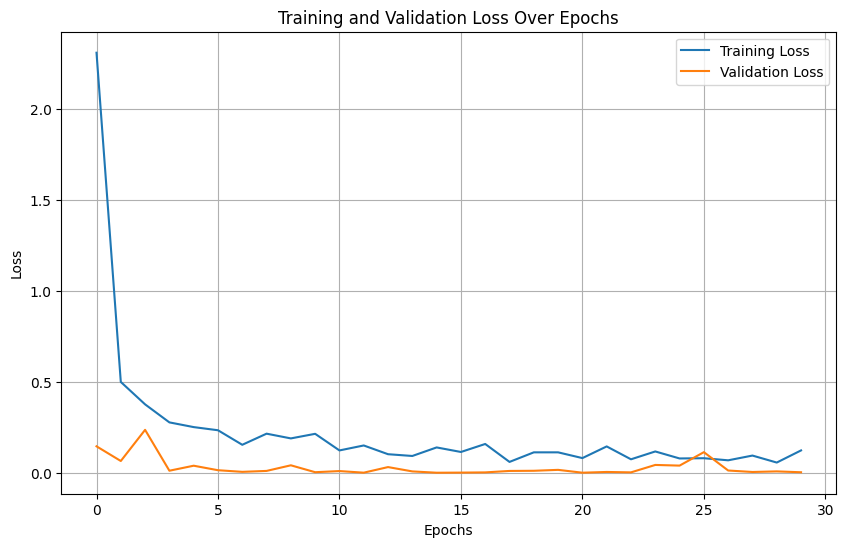

In [6]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Modeli kaydet
model.save('cnn_model.h5')
print("Model saved as cnn_model.h5")


Model saved as cnn_model.h5


In [6]:
updated_results_df

Model  Validation Accuracy  Validation Precision  \
0  Random Forest             0.836224              0.836337   
1        XGBoost             0.817277              0.817017   
2       LightGBM             0.821130              0.820247   
3            GBM             0.758189              0.758751   
4            SVM             0.633269              0.609141   
5            ANN             0.672447              0.673919   
6            CNN             0.992293              0.993165   

   Validation Recall  Validation F1 Score  Test Accuracy  Test Precision  \
0           0.836224             0.834702       0.839228        0.839196   
1           0.817277             0.815824       0.816399        0.816099   
2           0.821130             0.819935       0.826367        0.825908   
3           0.758189             0.753398       0.755949        0.755770   
4           0.633269             0.603399       0.634727        0.605447   
5           0.672447             0.658455       0.672347        0.673869   
6           0.992293             0.992262       0.993248        0.993907   

   Test Recall  Test F1 Score  
0     0.839228       0.838229  
1     0.816399       0.815430  
2     0.826367       0.825258  
3     0.755949       0.752075  
4     0.634727       0.604155  
5     0.672347       0.658986  
6     0.993248       0.993228

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image
import os

# Load and preprocess the data using PIL
def load_data_pil(data_dir, img_size=(100, 100)):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(img_size)
            images.append(np.array(img))
            labels.append(class_name)
    return np.array(images), np.array(labels), class_names

# Load data
train_images_pil, train_labels_pil, class_names_pil = load_data_pil(train_dir, img_size=(100, 100))

# Normalize the images to [0, 1]
train_images_pil = train_images_pil / 255.0

# Convert labels to categorical (one-hot encoded) labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_labels_pil)
y_dl = to_categorical(y_encoded, num_classes=len(class_names_pil))

# Split data into training and validation sets
X_train_cnn, X_val_cnn, y_train_dl, y_val_dl = train_test_split(train_images_pil, y_dl, test_size=0.2, random_state=42)

# Verify the shapes
print(X_train_cnn.shape, X_val_cnn.shape, y_train_dl.shape, y_val_dl.shape)


(4984, 100, 100, 3) (1247, 100, 100, 3) (4984, 24) (1247, 24)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the results
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names_pil), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


c:\Users\Baki Akgun\New Folder\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,659,672 (25.40 MB)

 Trainable params: 6,659,672 (25.40 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val_cnn, y_val_dl)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0010   
Validation Loss: 0.0010869487887248397
Validation Accuracy: 1.0


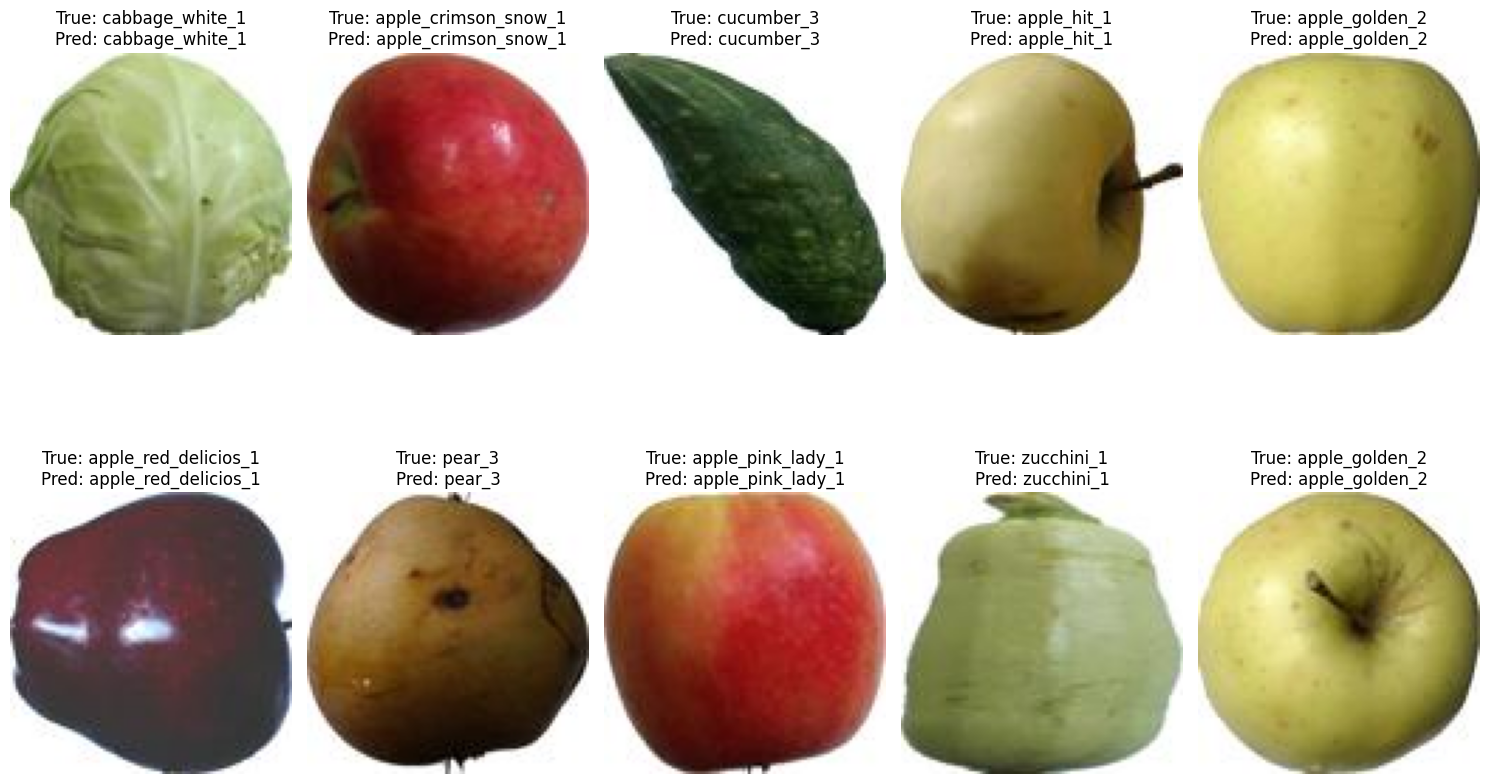

In [16]:
import random

# Görselleştirme için rastgele 10 görüntü seç
num_examples = 10  # Kaç tane tahmin göstermek istediğinizi belirtin
random_indices = random.sample(range(len(true_labels)), num_examples)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)  # 2 satır, 5 sütun düzeninde gösterim
    plt.imshow(val_images_pil[idx])  # Görüntüyü göster
    plt.title(f"True: {true_labels[idx]}\nPred: {predicted_labels[idx]}")
    plt.axis('off')  # Eksenleri kapat
plt.tight_layout()
plt.show()


### Check Model Predict

In [ ]:
from tensorflow.keras.models import load_model

# Modeli yükle
loaded_model = load_model('cnn_model.h5')
print("Model loaded successfully")



In [26]:
# Örnek bir görüntü yükleme ve işleme
import numpy as np
from PIL import Image

# Tahmin için görüntü yolu

image_path = r"C:\Users\Baki Akgun\OneDrive\Masaüstü\Fruit 360\fruits-360_dataset_100x100\Training\cucumber_3\r0_24.jpg"


image = Image.open(image_path).resize((100, 100))  # Görüntüyü boyutlandır
image_array = np.array(image) / 255.0  # Normalize et
image_array = np.expand_dims(image_array, axis=0)  # Batch boyutu ekle


In [27]:
# Tahmin yap
prediction = loaded_model.predict(image_array)
predicted_class = np.argmax(prediction, axis=1)  # En yüksek olasılık sınıfı
predicted_label = label_encoder.inverse_transform(predicted_class)  # Sınıf ismine çevir

print(f"Tahmin edilen sınıf: {predicted_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tahmin edilen sınıf: cucumber_3
